In [28]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Tutorial de Modelos de Regresión Lineal Múltiple

En este tutorial conocerás cómo adaptar modelos lineales a series de tiempo que presentan componentes estructurales tales como tendencia, estacionalidad y ruido. Particulamente, aprenderás a generar las estructuras de dependencia que conforman los features o variables explicativas más importantes del modelo, ingresarlos a una función típica de regresión lineal y obtener resultados. Usaremos una base de datos que ayuda a ejemplificar el uso de las diferentes paqueterías y funciones contempladas en este tutorial. Esta base es la base de datos de Amtrak, famosa por ser usada en una competencia de kaggle [1](#0)

El contenido de este tutorial está organizado de la siguiente manera. En la primera parte, generaremos un modelo con la paquetería de tslm(), donde partiremos de la importación de paqueterías y datos necesarios; aquí, modelaremos paso a paso cada uno de los componentes de la serie. En la segunda parte del tutorial, emplearemos una función básica de regresión lineal, la lm() para modelar las estructuras de la serie. En la tercera parte, aplicaremos la paquetería de ModelTime para el modelamiento, el cual genera otra manera de análisis y predicción de la series. En cada uno de estas partes, generaremos el pronóstico a futuro.

**Contenido**
1. [Modelación con función tslm()](#1) 
    1. [Importación de librerías requeridas](#2)
    1. [Importación de datos](#3)
    1. [Indexado de fecha y visualización](#4)
    1. [Identificación de features](#5)
    1. [Partición de datos de entrenamiento y prueba](#6)
    1. [Especificación del modelo de tendencia](#7)
    1. [Especificación del modelo de tendencia polinómica](#8)
    1. [Especificaciónd el modelo con estacionalidad](#9)
    1. [Especificación del modelo con todos los componentes](#10)
    1. [Obtención de métricas de error](#11)
    1. [Generación del pronóstico hacia adelante](#12)
1. [Modelación con función lm()](#13)
    1. [Importación de datos](#14)
    1. [Partición de datos de entrenamiento y prueba](#15)
    1. [Especificación del modelo lineal con lm()](#16)
    1. [Predicción con datos de prueba](#17)
    1. [Obtención de métricas de error](#18)
    1. [Generación del pronóstico hacia adelante](#19)
1. [Modelación con TimeModel()](#20)
    1. [Partición de datos en entrenamiento y prueba](#21)
    1. [Especificaicón del modelo lineal](#22)
    1. [Adición del modelo de ajuste a Model Table](#23)
    1. [Calibración y obtención de métricas de error](#24)
    1. [Generación del pronóstico hacia adelante](#25)

<a id="1"></a> <br>
## 1. Modelación con función tslm()

Comenzaremos este tutorial empleando la función de tslm() a la serie. Como verás, iremos generando modelos que contemplan los diferentes componentes de las series, para termiar con uno que incluye todos los componentes: tendencia lineal, polinómica y estacionalidades.

<a id="2"></a> <br>
## A. Importación de librerías requeridas

La importación incluye paquetes para el modelado de los datos, el manejo de las series y la visualización.

In [29]:
library(forecast)
library(fpp3)
library(tidymodels)
library(modeltime)
library(tidyverse)
library(lubridate)
library(timetk)
library(tsfeatures)
library(TSstudio)
interactive <- TRUE
options(warn = - 1) 

<a id="3"></a> <br>
### B. Importación de datos
La importación de datos la debes realizar a manera que subas el archivo llamado "Amtrak_data.csv", disponible en Github y en la plataforma. Su importación dependerá de tu perfil, si es público o privado. Si es privado, deberás contar con espacio disponible.

In [30]:
#Importar el data.csv
df<-read.csv("../input/amtrakcsv/Amtrak_data.csv", sep=";", header=TRUE)
head(df)

<a id="4"></a> <br>
### C. Indexado de fecha y visualización

Para facilitar las siguientes operaciones, tales de visualización y modelado, debes generar una columna con el formato de fecha, así como el formato particular tipo ts().

In [31]:
# Creamos columna de fecha, a partir de otra, que es la de Month.
df$Date<- as.Date(df$Month, format='%d/%m/%Y')
str(df)
head(df)

In [32]:
# Creamos una visualización.
df%>%plot_time_series(Date, Ridership, .interactive = interactive)

In [33]:
# Pasamos a formato tipo ts.
df.ts=ts(df$Ridership,  start = c(1991,1), end = c(2004, 3), freq = 12)
head(df.ts)

<a id="5"></a> <br>
### D. Identificación de features

Para la identificación de features o variables regresores a ingresar al modelo, podemos dar un vistazo a los features más relevantes de los datos, a través de la función tsfeatures(). Igualmente, podemos descomponer la serie para tener una visualización de la tendencia, estacionalidad y finalmente, podemos generar una visualización del comportamiento mensual de la variable de interés.

 

In [34]:
# Veamos los features.
tsfeatures(df.ts)

Mediante la función tsfeatures(), podemos observar que la serie posee datos anuales con frecuencia mensual, es decir, frecuencia 12 cada 1 periodo, así como periodos estacionales igualmente mensuales. La linealidad es superior a uno, lo cual es relevante. El nivel de entropia o de dificutad en la predicción, dada la presencia de estructuras complejas en la serie, está por debajo de 1. Otros features relacionan características más específicas de correlaciones seriales lineales y cuadráticas, pero por el momento, podemos retomar estas comentadas para tener idea de la buena elección en la aplicabilidad de los modelos lineales.

Veamos ahora los componentes de la serie, la función "multiple seasonal time serie decomposition by loess" o "mstl" genera una descompoisción empleando un algoritmo STL (Seasonal Decomposition of Time Series by Loess, que funciona por suavizamientos), donde se permiten estacionalidades múltiples y de manera automaizada llega a la descomposición óptima.

In [35]:
# Descomponenmos con la función mstl y visualizamos los componentes.
mstl(df.ts)%>%autoplot()+xlab("Month")

En la gráfica se observa que la tendencia que posee un comportamiento polinómico y su comportamiento mensual "Seasonal 12".

Otra técnica para visualizar los features relevantes, es mediante la visualización de los datos anuales con frecuencia mensual. Esta gráfica es útil ya que podemos darnos idea de qué meses o rezagos o features serán relevantes en el modelo lineal.

In [36]:
# Otra herramienta de visualización para el comonente de estacionalidad, es mediante la eliminación de la tendencia. Luego, imprimimos la de la estacionalidad.
detre= mstl(df.ts)
df_detrend <- df.ts - detre[,2]
ts_seasonal(df_detrend, type = "box")

<a id="6"></a> <br>
### E. Partición de datos de entrenamiento y prueba
Partamos la serie en entrenamiento y validación

In [37]:
# También podemos usar los tradicionales ACF y PACF.
acf(diff(df.ts), 60)
pacf(diff(df.ts), 60)

Vemos un patrón estacionario semestral en ACF.

In [38]:
# Partimos la serie, podemos tomar en porcentaje, o mediante la definición de valores.
nValid <- 36
nTrain <- length(df.ts) - nValid
entren.ts <- window(df.ts, start = c(1991, 1), end = c(1991, nTrain))
valid.ts <- window(df.ts, start = c(1991, nTrain + 1), end = c(1991, nTrain + nValid))

<a id="7"></a> <br>
### F. Modelos con tendencia
Vamos a aplicar un modelo de regresión lineal simple mediante la función tslm(), estableciendo la variable y y el predictor como la variable de tiempo:

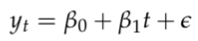

Donde Y_t es el valor de la respuesta en el tiempo t y e es el error estándar o ruido blanco del modelo de regresión. Así, modelaremos tres de los cuatro componentes de las series de tiempo: nivel (beta cero), tendencia (Beta 1), y ruido (e). La estacionalidad no la modelaremos ahorita, sino más adelante.

In [39]:
# Empleamos la función tslm(). Aquí, aplicamos la función de transformación de Box Cox automática mediante la función de lambda.
entren.lm = tslm(entren.ts~trend, lambda="auto")
summary(entren.lm)
#str(entrena.lm)
#train.lm.linear.trend <- tslm(train.ts ~ trend, lambda = 1)  #Si deseáramos aplicar una transformación logarítmica a la serie.

In [40]:
# En esta opción, eliminamos la función de transformación de datos con Box Cox. No es muy diferente.
entren.lm2 = tslm(entren.ts~trend)
summary(entren.lm2)

In [41]:
# Podemos graficar el resultado. Imprimimos primero la serie original y sobreponemos el ajuste.
plot(df.ts, xlab="Time", ylab="Ridership", ylim=c(1300,2300), bty="l", col="black")
lines(entren.lm$fitted, lwd=2, col="red")

In [ ]:
# Actualizamos librerías:
library(tsibble)
library(fable)
library(tidyverse)
library(TSstudio)
library(MAPA)

In [42]:
# Visualizamos los gráficos:
entren.lm.pred = forecast(entren.lm, h=nValid)
plot(entren.lm.pred, ylim=c(1300,2600), ylab="Ridership", xlab="Time", bty="l", xlim=c(1991,2006.25), main="", flty=2)
axis(1, at=seq(1991,2006,1), labels=format(seq(1991,2006,1)))
lines(entren.lm.pred$fitted, lwd=2,col="red")
lines(valid.ts)
lines(entren.ts)
lines(c(2004.25 - 3, 2004.25 - 3), c(0, 3500)) 
lines(c(2004.25, 2004.25), c(0, 3500))
text(1996.25, 2500, "Entrenamiento")
text(2002.75, 2500, "Validacion")
text(2005.25, 2500, "Futuro")
arrows(2004 - 3, 2450, 1991.25, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5 - 3, 2450, 2004, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5, 2450, 2006, 2450, code = 3, length = 0.1, lwd = 1, angle = 30)


Si observamos el resultado de la regresión, vemos que dista mucho del comportamiento real. Ante ello, procederemos a incluir una complejidad mayor a la tendencia, así como el resto de los componentes.

<a id="8"></a> <br>
### G. Modelos con tendencia polinómica

En esta sección, ingresaremos en el código que la tendencia se comporta cuadráticamente, para tratar de captar mejor su comportamiento.

In [43]:
entren.lm.poli = tslm(entren.ts~trend+I(trend^2))
summary(entren.lm.poli)

In [44]:
entren.lm.poli.pred = forecast(entren.lm.poli, h=nValid)
plot(entren.lm.pred, ylim=c(1300,2600), ylab="Ridership", xlab="Time", bty="l", xlim=c(1991,2006.25), main="", flty=2)
axis(1, at=seq(1991,2006,1), labels=format(seq(1991,2006,1)))
lines(entren.lm.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$mean, lwd = 2,lty = 3, col="lightblue")
lines(valid.ts)
lines(entren.ts)
lines(c(2004.25 - 3, 2004.25 - 3), c(0, 3500)) 
lines(c(2004.25, 2004.25), c(0, 3500))
text(1996.25, 2500, "Entrenamiento")
text(2002.75, 2500, "Validacion")
text(2005.25, 2500, "Futuro")
arrows(2004 - 3, 2450, 1991.25, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5 - 3, 2450, 2004, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5, 2450, 2006, 2450, code = 3, length = 0.1, lwd = 1, angle = 30)


Vemos que este modelo mejoró ante el anterior que sólamente incluía una tendencia lineal. Sin embargo, podemos incluir el componente de estacionalidad, que no ha sido considerado al momento.

<a id="9"></a> <br>
### H. Modelos con estacionalidad

Retomaremos el modelo anterior e incluiremos el componente de la estacionalidad, cuyo feature es relevante a partir de la visualización de la descomposición de la sere.

In [45]:
entren.lm.season <-tslm(entren.ts~season)  #notar que season es con minuscula, no es el nombre de la columna del mes.
summary(entren.lm.season)

<a id="10"></a> <br>
### I. Modelos con todos los componentes

Incluyamos ahora, todos los componentes en el modelo de regresión:

In [46]:
entren.lm.compo <-tslm(entren.ts~trend+I(trend^2)+season)  #notar que season es con minúscula, no es el nombre de la columna del mes.
summary(entren.lm.compo)

In [47]:
#Generamos su visualización:
entren.lm.compo.pre = forecast(entren.lm.compo, h=nValid)
plot(entren.lm.pred, ylim=c(1300,2600), ylab="Ridership", xlab="Time", bty="l", xlim=c(1991,2006.25), main="", flty=2)
axis(1, at=seq(1991,2006,1), labels=format(seq(1991,2006,1)))
lines(entren.lm.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$mean, lwd = 2,lty = 3, col="orange")
lines(entren.lm.compo.pre$fitted, lwd=2,col="red")
lines(entren.lm.compo.pre$mean, lwd = 2,lty = 3, col="orange")
lines(valid.ts)
lines(entren.ts)
lines(c(2004.25 - 3, 2004.25 - 3), c(0, 3500)) 
lines(c(2004.25, 2004.25), c(0, 3500))
text(1996.25, 2500, "Entrenamiento")
text(2002.75, 2500, "Validacion")
text(2005.25, 2500, "Futuro")
arrows(2004 - 3, 2450, 1991.25, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5 - 3, 2450, 2004, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5, 2450, 2006, 2450, code = 3, length = 0.1, lwd = 1, angle = 30)


Vemos que este último modelo genera un mejor ajuste a los datos. Ante ello, procedemos a la obtención de métricas de error, para conocer la precisión del pronóstico empleando el conjunto de datos de prueba.

<a id="11"></a> <br>
### J. Obtención de métricas de error

Ahora, calculemos las métricas de RMSE y MAPE, como ejemplos de métricas de error de escala y porcentual en el pronóstico de los datos de prueba.

In [48]:
#Métricas:
library(Metrics)
rmse_tslm_poli<-rmse(valid.ts, entren.lm.compo.pre$mean)
rmse_tslm_poli
mape_tslm_poli<-mape(valid.ts, entren.lm.compo.pre$mean)
mape_tslm_poli

<a id="12"></a> <br>
### K.Generación del pronóstico hacia adelante

Para el pronóstico forward o futuro, generamos la función de ajuste a todos los datos de la serie e ingresando todos los componentes de la serie, incluyendo el término cuadrático que resultó ser relevante. Es importante recalcar que en esta situación, no debemos generar los features ya que la función lo genera de manera automática.

In [49]:
# Aplicamos función tslm()
lm_all <-tslm(df.ts~trend+I(trend^2)+season)  #notar que season es con minúscula, no es el nombre de la columna del mes.
summary(lm_all)

Como vemos, los resultados son muy similares a los obtenidos por la función de lm(). Generamos entonces, el pronóstico a través de la función forecast(), indicando los pasos a pronosticar. Esto quiere decir que el modelo emplea los últimos 30 datos para generar los 30 datos futuros, aplicados al modelo de regresión.

In [50]:
# Generamos su visualizaicón:
pron_fwd = forecast(lm_all, h=30)
plot(entren.lm.pred, ylim=c(1300,2600), ylab="Ridership", xlab="Time", bty="l", xlim=c(1991,2006.25), main="", flty=2)
axis(1, at=seq(1991,2006,1), labels=format(seq(1991,2006,1)))
lines(entren.lm.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$fitted, lwd=2,col="red")
lines(entren.lm.poli.pred$mean, lwd = 2,lty = 3, col="orange")
lines(entren.lm.compo.pre$fitted, lwd=2,col="red")
lines(entren.lm.compo.pre$mean, lwd = 2,lty = 3, col="orange")
lines(pron_fwd$mean, lwd = 2,lty = 3, col="pink") ##Futuro: FWD Forecast
lines(valid.ts)
lines(entren.ts)
lines(c(2004.25 - 3, 2004.25 - 3), c(0, 3500)) 
lines(c(2004.25, 2004.25), c(0, 3500))
text(1996.25, 2500, "Entrenamiento")
text(2002.75, 2500, "Validacion")
text(2005.25, 2500, "Futuro")
arrows(2004 - 3, 2450, 1991.25, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5 - 3, 2450, 2004, 2450, code = 3, length = 0.1, lwd = 1,angle = 30)
arrows(2004.5, 2450, 2006, 2450, code = 3, length = 0.1, lwd = 1, angle = 30)

De esta manera, vemos que se obtienen muy buenos resultados a través de la aplicación de esta función.

Ahora veamos, otra manera de realizar el modelamiento, que es a través de la función de lm() y porteriormente de ModelTime.

<a id="13"></a> <br>
# Modelación con función lm()

Ahora, probemos un tipo de modelamiento a través de la función lm() tradicional. Para ello, deberemos capturar los features de la serie, usualmente se generan estos a través de funciones de retrasos o lag(), así como la generación de tendencias las cuales van cambiando unidad por unidad. Esta generación de features se va dando a manera de ir formando nuenvas columnas.


<a id="14"></a> <br>
### A. Importación de datos

Incluyo estos pasos ya previamente realizados, pero para facilidad de lectura en el ejercicio, rellamemos a los datos, indexemos la fecha.

In [51]:
# Importamos los datos:
df<-read.csv("../input/amtrakcsv/Amtrak_data.csv", sep=";", header=TRUE)
head(df)

In [52]:
# GEneramos la columna de date
df$Date<- as.Date(df$Month, format='%d/%m/%Y')
str(df)
head(df)

In [53]:
#Esta librería es útil para la generación de rezagos:
library(DataCombine)

Y generamos los features, rezagos correspondientes.

In [54]:
# Generamos los rezagos:
df1 <- slide(df, Var = "Ridership", slideBy = -1) 
df2 <- slide(df1, Var = "Ridership", slideBy = -2) 
df3 <- slide(df2, Var = "Ridership", slideBy = -3) 
df4 <- slide(df3, Var = "Ridership", slideBy = -4) 
df5 <- slide(df4, Var = "Ridership", slideBy = -5)
df6 <- slide(df5, Var = "Ridership", slideBy = -6) %>%na.omit()
colnames(df6) <- c("Month", "Ridership","Season","t", "Date", "l1", "l2", "l3", "l4",  "l5", "l6")
tail(df6)

In [55]:
# Agregamos la tendencia:
df6$trend = 1:nrow(df6)
df6$trend2 = df6$trend^2
#df.ts$trend3 = 1:nrow(df.ts)$trend^3 # si se requiriera una tendencia cúbica
str(df6)
head(df6)
tail(df6)

In [56]:
# Por facilidad, puedes renombrar el objeto.
ldf<-df6

<a id="15"></a> <br>
### B.Partición datos de entrenamiento y prueba

En esta parte, vamos a considerar el mismo horizonte del pronóstico empleado en el modelo con tslm().

In [57]:
##h: horizonte pronostico
h <- 36
ldf_train <- ldf[1:(nrow(ldf) - h), ]
ldf_test<- ldf[(nrow(ldf) - h + 1):nrow(ldf), ]
tail(ldf_train)
head(ldf_test)

<a id="16"></a> <br>
### C. Especificación del modelo lineal con lm()

Una vez creada la base de datos con los features, procedemos a emplear la función lm().

In [58]:
####Modelo de referencia: Modelo lineal
lm_ldf <- lm(Ridership ~ l1 + l2  + l3 + l4 +l5 +l6 + trend + trend2, data = ldf_train)
summary(lm_ldf)
#Vemos que varios features no son relevantes, por ello, depuramos el modelo.

In [59]:
####Modelo depurado:
lm_ldf2 <- lm(Ridership ~ l1+l6 + trend + trend2, data = ldf_train)
summary(lm_ldf2)

<a id="17"></a> <br>
### D. Predicción con datos prueba

En esta sección aplicamos la función de predict(), aplicando el modelo depurado, especificando que es una serie de tiempo con "ts=TRUE".

In [60]:
# Generamos una columna con los resultados del modelo de predicción  que llamamos "yhat".
ldf_test$yhat <- predict(lm_ldf2, newdata = ldf_test, ts=TRUE)
head(ldf_test)
str(ldf_test)

Grafiquemos los resultados empleado la función de plotly, especificando las fechas de estudio mediante la generación de fechas en formato "as.Date", indicando qué elementos son de eje "x" o fechas y cuáles de "y". En el resto de líneas, agregamos los resultados de pronóstico en el conjunto de datos de prueba.

In [61]:
# Llamamos primeramente la librería y procedemos a indicar las características de la visualización.
library(plotly)
start<-format(as.Date("1991-01-01"),"%Y-%m-%d")
end<-format(as.Date("2004-03-01"),"%Y-%m-%d")
plot_ly(x = ldf$Date, y = ldf$Ridership,
        type = "scatter",
        mode = "line", 
        name = "Actual") %>% 
  add_lines(x = ldf_test$Date, y = ldf_test$yhat, name = "LM") %>%
  layout(title = "LM Forecast", yaxis = list(title = "Ridership @ Los Andes", range = c(1000, 3000)),
         xaxis = list(title = "Date", range = c(start, end)))

<a id="18"></a> <br>
### E. Obtención de métricas de error

Una vez generado el pronóstico en los datos de prueba, podemos medir la precisión de los resultados mediante métricos de error. Usualmente empleamos métricos de escala y de porcentaje, tales como el RMSE y el MAPE, respectivamente. 

In [62]:
# Comenzamos con la importación de la librería Metrics.
library(Metrics)
mape_lm_ldf <- mape(ldf_test$Ridership, ldf_test$yhat)
mape_lm_ldf
rmse_lm_ldf <- rmse(ldf_test$Ridership, ldf_test$yhat)
rmse_lm_ldf

In [63]:
# Podemos comparar con las métricas obtenidas con tslm():
mape_tslm_poli
rmse_tslm_poli

El algoritmo de tslm ofrece mejores desempeños.

<a id="19"></a> <br>
### F. Generación de pronóstico hacia adelante
Primero, generamos un ajuste a toda la serie para obtener la ecuación model; para ello, debemos generar nuevamente todos los features para el modelo lm(). Posteriormente, aplicamos función predict.lm, que emplea los datos de ajuste para generar el pronóstico.

In [64]:
# Retomamos los datos iniciales en formato data frame:
head(df)

In [65]:
# Generamos los rezagos a toda la base
df1f <- slide(df, Var = "Ridership", slideBy = -1) 
df2f <- slide(df1f, Var = "Ridership", slideBy = -2) 
df3f <- slide(df2f, Var = "Ridership", slideBy = -3) 
df4f <- slide(df3f, Var = "Ridership", slideBy = -4) 
df5f <- slide(df4f, Var = "Ridership", slideBy = -5)
df6f <- slide(df5f, Var = "Ridership", slideBy = -6) %>%na.omit()
colnames(df6f) <- c("Month", "Ridership","Season","t", "Date", "l1", "l2", "l3", "l4",  "l5", "l6")


In [66]:
# Generamos los features de tendencia lineal y cuadrática.
tail(df6f)
df6f$trend = 1:nrow(df6f)
df6f$trend2 = df6f$trend^2
#df.ts$trend3 = 1:nrow(df.ts)$trend^3 # si se requiriera un atendencia cúbica
str(df6f)
#tail(df6f)

In [67]:
# Generamos el modelo de regresión con lm()
lm_df6f<-lm(Ridership ~ l1 + l2  + l3 + l4 +l5 +l6 + trend + trend2, data = df6f)
summary(lm_df6f)

Para poder generar pronósticos futuros, se debe aplicar el modelo a una estructura de datos donde se tomen los últimos valores para predecir los futuros. Una vez generados, podemos crear la secuencia de fechas para estos mediante la función seq(), que ayudará a la visualización.

In [68]:
# Generamos el pronóstico hacia adelante
lm_fwd <- predict.lm(lm_df6f, interval = "prediction")[118:153,]
head(lm_fwd)
tail(lm_fwd)

In [69]:
# Generamos la secuencia de fechas a dichos valores
starter_df <- data.frame(dates=seq(from=(as.POSIXct(strftime("2004-04-01"))),
                               length.out = 36, 
                               by="1 month"),
                     data = lm_fwd)

In [70]:
# Asignamos a esas fechas un formato requerido para el gráfico
full_data <- data.frame(dates=seq(from=min(starter_df$dates),
to=max(starter_df$dates), by="1 month"),
data=rep(NA,NROW(seq(from=min(starter_df$dates),
to=max(starter_df$dates), by="1 month"))))

full_data[full_data$dates %in% starter_df$dates,] <- starter_df[starter_df$dates %in% full_data$dates,]
head(full_data)

In [71]:
# Gráfico:
library(plotly)
start<-format(as.Date("1991-01-01"),"%Y-%m-%d")
end<-format(as.Date("2005-02-01"),"%Y-%m-%d")
plot_ly(x = ldf$Date, y = ldf$Ridership,
        type = "scatter",
        mode = "line", 
        name = "Actual") %>% 
  add_lines(x = ldf_test$Date, y = ldf_test$yhat, name = "LM") %>%
  add_lines(x = full_data$dates, y = full_data$data, name = "LM FWD") %>%
  layout(title = "LM Forecast", yaxis = list(title = "Ridership @ Los Andes", range = c(1000, 3000)),
         xaxis = list(title = "Date", range = c(start, end)))

<a id="20"></a> <br>
## 3. Modelación con TimeModel()

Como es usual en el manejo de funciones que involucran series de tiempo, al aemplear esta paquetería es necesario convertir los datos en formato data frame. Posteriormente, vamos a partir la serie en conjunto de entrenamiento y prueba mediante la función de time_series_split(). Posteriormente, camos a definir modelo para después adicionarlo a un formato de TimeTable. Lo vamos a calibrar que significa que el modelo se va a aplicar a toda la serie y va a generar ajustes al mismo para así obtener el modelo final; posteriormente procederemos con el cálculo de los métricos de error de pronóstico. Finalmente, aplicaremos la función de pronóstico futuro.

<a id="21"></a> <br>
### A. Partición de datos en entrenamiento y prueba

Comencemos partiendo la serie. Este paso usualmente debiera ser el que procede a la importación de datos, el cual ya hemos realizado previamente.

In [72]:
# La función de time_series_split genera en un solo paso, la partición de la serie, especificando el periodo respectivo para la prueba.
splits <- df %>%
  time_series_split(assess = "36 months", cumulative = TRUE)

In [73]:
# Podemos visualiar la serie con el conjunto de entrenamiento y de prueba, además, adicionando una lpinea de suavizamiento a la tendecia. 
# Podemos también solicitar que la visualización sea interactiva o no. En este caso, optamos por interactiva.
splits %>%
  tk_time_series_cv_plan() %>%
  plot_time_series_cv_plan(Date, Ridership, .interactive = TRUE)

<a id="22"></a> <br>
### B.Especificación del modelo lineal

En esta parte del proceso, vamos a generar el modelo lineal. En este caso, no es necesaria la generación previa de features en la base de datos, ya que la función fit() del modleo lineal de esta paquetería, los genera automáticamente.

In [74]:
# Especificamos que la fecha sea numérica y que los features se traten como factores. Importante indicar ordered como FALSE para que conserve el ordenamiento de fechas y no de valores.
model_fit_lm <- linear_reg() %>%
    set_engine("lm") %>%
    fit(Ridership ~ as.numeric(Date) + factor(month(Date),ordered = FALSE),
        data = training(splits))
# model_fit_lm  #Si deseamos observar el resultado del modelo

<a id="23"></a> <br>
### C. Adición del modelo de ajuste a ModelTable

Los siguientes pasos serán el adicionar el modelo de ajuste antes creado con todos los datos para generar una calibración del mismo. Este proceso involucra que el modelo anterior sea adicionado a la estructura llamada ModelTime.

Este paso hace algunas revisiones básicas para asegurarse que cada uno de los modelos son en sí ajustados a los datos y con ello, se organiza una estructura escalable llamada "Modeltime Table", que se usa como parte del proceso de pronóstico.

<a id="24"></a> <br>
### D. Calibración y obtención de métricas de error

In [75]:
# Calibramos:
calibration_tbl <- model_fit_lm %>%
    modeltime_calibrate(new_data = testing(splits))

In [76]:
library(ddpcr)
##Nueva Calibración del Modelo con toda la serie
calibration_tbl %>%
    modeltime_forecast(
        new_data    = testing(splits),
        actual_data = df) %>% quiet(all = TRUE)

In [77]:
# Generamos la calibración como se indicó a toda la base de datos para generar los métricos de precisión o "accuracy". 
calibration_tbl %>%
    modeltime_accuracy() %>%
    table_modeltime_accuracy(
        .interactive = interactive
    )

<a id="25"></a> <br>
### E. Generación del pronóstico hacia adelante

Una vez obtenido el modelo y los métricos, generamos el pronóstico hacia adelante. En el caso se tuvieran varios modelos de especificación dentro el ModelTime, el pronóstico hacia adelante se realiza con el modelo que generó los menores valores de error.

In [78]:
# Retomamos el modelo ajustado, indicamos el horizonte en días. Este es equivalente a los horizontes de los modelos tipo tslm() y lm()
refit_tbl <- calibration_tbl %>%
    modeltime_refit(data = df)
refit_tbl %>%
    modeltime_forecast(h = "360 days", actual_data = df) %>%
    plot_modeltime_forecast(
      .legend_max_width = 25, 
      .interactive      = interactive
    )

Como podemos observar, el pronóstico hacia adelante generó resultados muy similares a aquellos encontrados mediante las funciones tslm() y lm(). La elección de la paquetería y funciones dependerá tanto de la afinidad del usuario por alguna particular y también, a la facilidad que posee el preprocesamiento de los datos. Es muy común que series que poseen frecuencias diarias y carentes de estacionalidad, no sean buenos candidatos para ser modelados directamente a través de funciones tales como tslm() o la TimeModel; de ahí, la utilidad de la versatilidad de la función lm() que responderá a la creación de los features y modelación que el programador diseñe.

En este tutorial, se estudiaron tres diferentes maneras de generar modelos de regresión para el pronóstico en series de tiempo. Empleando la función tslm(), la función lm() y la función de regresión lineal a través de ModelTime().

Las funciones de tslm() y de modelo lineal con ModelTime facilitan el proceso de modelado y pronóstico. Estas funciones se desempeñan muy bien cuando las series presentan tendencias significativas, así como frecuencias diferentes a las diarias. Sin embargo, cuando las series presentan frecuencias diarias o carecen de componentes estacionales simples, estas funciones pueden requerir pasos adicionales a las aquí presentadas a menera de poder ser modeladas con dichas funciones. Sin embargo, representan un punto de referencia para la comparación de modelos de regresión y pronóstico.

### Referencias:
<a id="0"></a> <br>
NJ Transit + Amtrak (NEC) Rail Performance- COnsultado el 26 Agosto 2022. Fuente: https://www.kaggle.com/datasets/pranavbadami/nj-transit-amtrak-nec-performance